# Geometric operations
Make an overlay analysis where we select only specific polygon cells from the data based on the borders of municipality of Helsinki.

In [1]:
# Necessary imports
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from ipywidgets import FloatProgress
from IPython.display import display
import time
%matplotlib inline

## Overlay Analysis
Select data from overlapping regions.

In [3]:
# Download data from:
# https://github.com/Automating-GIS-processes/Lesson-4-Classification-overlay/raw/master/data/data.zip
# Contains a 'travel time matrix'. Copy all files to Data/

# Load the data and region border as a GeoDataFrame
borderFile = "Data/Helsinki_borders.shp"
gridFile = "Data/TravelTimes_to_5975375_RailwayStation.shp"
grid = gpd.read_file(gridFile)
hel = gpd.read_file(borderFile)
grid.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000.0001358641 6697750.000038058,..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250.0001358146 6697750.000038053,..."
2,30133,50,31872,56,5785642,32940,121,146,32940,113,133,5975375,29626,423,"POLYGON ((382500.0001357661 6697750.000038046,..."
3,32690,54,34429,60,5785643,33233,125,150,33233,117,144,5975375,29919,427,"POLYGON ((382750.0001357181 6697750.000038039,..."
4,31872,42,31834,48,5787544,32127,109,126,32127,101,121,5975375,31674,452,"POLYGON ((381250.0001360176 6697500.000038121,..."


In [4]:
# Check coord systems match
print(hel.crs, grid.crs)

{'init': 'epsg:3067'} {'init': 'epsg:3067'}


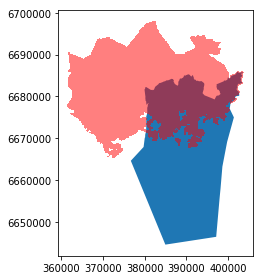

In [5]:
# Plot the datasets
baseAx = hel.plot()
grid.plot(ax=baseAx, linewidth=0.02, color="r", alpha=0.5);
plt.tight_layout()

In [6]:
# Do an overlay analysis to select polygons from the grid that overlap the Helsinki border

# Direct way can be quite slow, so use 
#result = gpd.overlay(grid, hel, how='intersection')

# Batch method
batchSize = 10
nIter = int(np.ceil(len(grid) / batchSize))
result = gpd.GeoDataFrame()
iStart = 0
iEnd = iStart + batchSize

# Display a progress bar
f = FloatProgress(min=0, max=nIter) 
display(f)

for i in range(nIter):
    f.value += 1 
    
    # Make an overlay analysis using a subset of the rows and append to result
    tmp = gpd.overlay(grid[iStart:iEnd], hel, how='intersection')
    result = result.append(tmp)

    # Update indices
    iStart += batchSize
    iEnd = iStart + batchSize    

FloatProgress(value=0.0, max=1324.0)

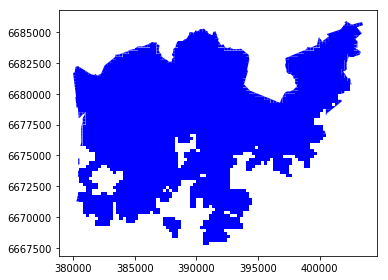

In [7]:
# Plot the result: shows only the overlap region
result.plot(color="b")
plt.tight_layout()


In [8]:
# Result also contains data from both input tables
result.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,29476,41,29483,46,5876274,29990,76,95,24984,77,99,5975375,25532,365,27517366,Helsinki,Helsingfors,091,"POLYGON ((402024.2242006524 6685750.00003958, ..."
1,29456,41,29462,46,5876275,29866,74,95,24860,75,93,5975375,25408,363,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.0001322502 6685834.729439409,..."
2,36772,50,36778,56,5876278,33541,116,137,44265,130,146,5975375,31110,444,27517366,Helsinki,Helsingfors,091,"POLYGON ((403148.5153944666 6685750.000039551,..."
3,36898,49,36904,56,5876279,33720,119,141,44444,132,155,5975375,31289,447,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.0001320575 6685774.118802304,..."
0,29059,41,29065,46,5878132,29357,67,89,24351,68,84,5975375,24899,356,27517366,Helsinki,Helsingfors,091,"POLYGON ((403000.0001321079 6685714.068098178,..."


## Aggregating data
Merge Geometries into together by some common identifier. Here we aggregate our travel time data by car travel times, i.e. the grid cells that have the same travel time to Railway Station will be merged together.

In [9]:
# Do a groupby followed by an aggragate
resultAgg = result.dissolve(by="car_r_t")
resultAgg.head()

,geometry,car_m_d,car_m_t,car_r_d,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE
car_r_t,,,,,,,,,,,,,,,,,,
-1,(POLYGON ((388000.0001354737 6669000.000042855...,-1,-1,-1,5913094,-1,-1,-1,-1,-1,-1,-1,-1,-1,27517366,Helsinki,Helsingfors,091
0,"POLYGON ((386000.0001357752 6672250.000042347,...",0,0,0,5975375,0,0,0,0,0,0,5975375,0,0,27517366,Helsinki,Helsingfors,091
7,"POLYGON ((386250.000135732 6672000.000042383, ...",1051,7,1051,5973739,617,5,6,617,5,6,5975375,448,6,27517366,Helsinki,Helsingfors,091
8,(POLYGON ((386250.0001357396 6671750.000042424...,1033,7,1033,5973738,653,9,9,653,9,9,5975375,653,9,27517366,Helsinki,Helsingfors,091
9,"(POLYGON ((387000.000135593 6671750.000042402,...",1871,9,1871,5970457,1384,11,13,1394,11,12,5975375,1249,18,27517366,Helsinki,Helsingfors,091


In [10]:
print(len(resultAgg))

51


In [12]:
# Save the records to a shapefile
resultAgg.to_file("Data/TravelTimes_to_5975375_RailwayStation.shp")